<a href="https://colab.research.google.com/github/tejasnavalkhe/Optimising-Car-Sharing-Profitability-with-a-Regional-Pricing-Strategy/blob/master/code/Rates%20Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load library and data

## 1.1. Load library

In [1]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.6 MB/s eta 0:00:00


In [2]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import warnings
from scipy import stats
from matplotlib.ticker import FuncFormatter
from category_encoders import BinaryEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import joblib

# Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# Data location
DATA_PATH = "/content/drive/MyDrive/MSc Dissertation/data/"
# Encoders location
ENCODERS_PATH = "/content/drive/MyDrive/MSc Dissertation/encoders/"
# Model location
MODEL_PATH = "/content/drive/MyDrive/MSc Dissertation/models/"

Mounted at /content/drive


## 1.2. Load data

In [3]:
raw_df = pd.read_csv(DATA_PATH + '2024 Bookings.csv')
tariff_df = pd.read_csv(DATA_PATH + 'Diff Tariffs.csv')
raw_df.head()

,account_id,Contract,user_id,vehicle_description,vehicle_registration,vehicle_communication_id,vehicle_operator_name,vehicle_office_use,location_description,location_office_use,booking_id,booking_reservation,booking_maintenance,booking_start,booking_end,booking_duration,booking_actual_start,booking_actual_end,booking_actual_duration,booking_billed_start,booking_billed_end,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_estimated_cost,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_credits_used,booking_transactions_value,booking_total_paid,booking_status,booking_ended_early,booking_created_at,booking_cancelled_at,booking_cancellation_reason
0,d4470f76-e885-11ee-85ef-e36c0de5945c,PAYG,4facab36-e885-11ee-a3bd-07de9431abb8,White Toyota Corolla Petrol Hybrid Estate (Aut...,NL70 BXV,1502,Co-wheels,PAYG,Reading - University Whiteknights Campus,REA005,8a874d26-10a6-11ef-ad23-5f794c6a9a23,96748829,no,05/12/2024 23:45,5/13/2024 10:30,645,5/13/2024 3:07,5/13/2024 8:42,335,05/12/2024 23:45,5/13/2024 10:30,645,33.0,Co-wheels Standard Large,0.00,1,0,59.20,7.92,59.20,67.12,0,-67.12,67.12,ended,no,05/12/2024 22:28,NaN,NaN
1,ad4720a8-371c-11e8-9c54-45ef183a979b,Contract,c7b038e0-7498-11ec-8cc3-71fcb7a46099,Toyota RAV4 Hybrid (Automatic) - NL71 GJK,NL71 GJK,1680,Co-wheels,Pool Car - Telematics,North Shields - North Tyneside General Hospital,NTH006,0e355148-10ae-11ef-a785-871fd5ad059c,96748838,no,05/12/2024 23:15,5/13/2024 8:15,540,5/13/2024 0:59,5/13/2024 7:41,402,05/12/2024 23:15,5/13/2024 8:15,540,6.0,"Billing Exempt (24/7) (Default, Co-wheels)",9.00,0,0,0.00,0.00,0.00,0.00,0,0.00,0.00,ended,no,05/12/2024 23:22,NaN,NaN
2,bf50a572-ad2c-11e8-8b49-31a8e401ec81,Contract,eeadfff2-f036-11e8-a070-b5d4b9914a5e,Toyota RAV4 Hybrid (Automatic) - NL71 GFO,NL71 GFO,1678,Co-wheels,Pool Car - Telematics,Bedlington - Foundry House,NTH003,11b2208c-10a2-11ef-8301-3f52737f5ce6,96748825,no,05/12/2024 22:45,5/13/2024 8:00,555,05/12/2024 23:06,5/13/2024 7:35,509,05/12/2024 22:45,5/13/2024 8:00,555,48.0,"Billing Exempt (24/7) (Default, Co-wheels)",9.25,0,0,0.00,0.00,0.00,0.00,0,0.00,0.00,ended,no,05/12/2024 21:56,NaN,NaN
3,6ac5731a-845f-11e9-8302-0b50d458dea3,PAYG,ec665b10-845e-11e9-97c2-d5ae114ceffd,White Toyota Yaris Petrol Hybrid (Automatic) -...,NC19 KYV,1291,Co-wheels,PAYG - Funded,Glasgow - Coustonholm Road,GLA024,a5e831b6-107e-11ef-9cc1-d71c27abf5d8,96748719,no,05/12/2024 22:30,05/12/2024 23:00,30,05/12/2024 22:32,05/12/2024 23:01,29,05/12/2024 22:30,05/12/2024 23:00,30,7.0,Glasgow Everyday,0.50,0,0,2.88,1.54,2.88,4.42,0,-4.42,4.42,ended,no,05/12/2024 17:42,NaN,NaN
4,bf50a572-ad2c-11e8-8b49-31a8e401ec81,Contract,ebad311e-ae10-11ed-8108-51e469acfaa6,Toyota RAV4 Hybrid (Automatic) - NL71 GFK,NL71 GFK,1677,Co-wheels,Pool Car - Telematics,Bedlington - Foundry House,NTH003,5ff3faba-07d6-11ef-b3bf-e375787a181c,96741857,no,05/12/2024 22:15,5/13/2024 8:00,585,05/12/2024 22:13,5/13/2024 7:37,564,05/12/2024 22:15,5/13/2024 8:00,585,52.0,"Billing Exempt (24/7) (Default, Co-wheels)",9.75,0,0,0.00,0.00,0.00,0.00,0,0.00,0.00,ended,no,05/01/2024 17:17,NaN,NaN


## 1.3. Load encoders

In [4]:
# Load the encoders
binary_encoder = joblib.load(ENCODERS_PATH + 'binary_encoder.pkl')
one_hot_encoder = joblib.load(ENCODERS_PATH + 'one_hot_encoder.pkl')

# 2. Data Preprocessing

## 2.1. Historical hourly and daily rates

In [5]:
# Define a function to apply rates based on year, month, vehicle type, fuel type and location of historical data

def apply_rates(row):
    year = row['booking_billed_start'].year
    month = row['booking_billed_start'].month
    location = row['location']
    vehicle_type = row['Vehicle Type']
    fuel_type = row['Fuel Type']

    # Initialize default rates
    hourly_rate = np.nan
    daily_rate = np.nan
    per_mile = np.nan

    # Determine rates based on the year, month, vehicle type, and location
    # First handle historical rates
    if year < 2022 or (year == 2022 and month == 1):
        # Historical rates before 2022
        rates = {'Small': (4.75, 33.25, 0.18), 'Medium': (5.50, 38.50, 0.18),
                 'Large': (6.25, 43.75, 0.18), 'Family': (7.25, 50.75, 0.20),
                 'Van': (7.50, 60.00, 0.22), '7 Seater': (7.50, 60.00, 0.22)}
        vehicle_size = row.get('Size Category')
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_size, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            hourly_rate = 5.50
            daily_rate = 38.50
            per_mile = 0.18
    elif year == 2022 and month >= 2 and month <= 10:
        rates = {'City': (5.00, 40.00, 0.20), 'Everyday': (5.75, 46.00, 0.20),
                 'Family': (6.50, 52.00, 0.22), '7 Seater': (7.50, 60.00, 0.22),
                 'Van': (7.50, 60.00, 0.22), 'Hydrogen': (7.50, 60.00, 0.31)}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            ev_rates = {'City': 0.05, 'Everyday': 0.05, 'Family': 0.05,
                        '7 Seater': 0.07, 'Van': 0.07}
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif year == 2022 and month >= 11 or (year == 2023 and month <= 8):
        rates = {'City': (5.00, 40.00, 0.22), 'Everyday': (5.95, 47.60, 0.22),
                 'Family': (6.70, 53.60, 0.22), '7 Seater': (7.70, 61.60, 0.24),
                 'Van': (7.70, 61.60, 0.24), 'Hydrogen': (7.70, 61.60, 0.31)}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            ev_rates = {'City': 0.12, 'Everyday': 0.12, 'Family': 0.12,
                        '7 Seater': 0.12, 'Van': 0.12}
            per_mile = ev_rates.get(vehicle_type, per_mile)
    # Detailed location-specific adjustments from September 2023 onwards
    elif location == 'Glasgow' and year >= 2023 and month >= 9:
        rates = {'City': (4.95, 39.60, 0.22), 'Everyday': (5.75, 46.00, 0.22),
                 'Family': (6.50, 52.00, 0.22), '7 Seater': (7.50, 60.00, 0.24),
                 'Van': (7.50, 60.00, 0.24), 'Hydrogen': (7.50, 60.00, 0.31)}
        ev_rates = {'City': 0.12, 'Everyday': 0.12, 'Family': 0.12,
                    '7 Seater': 0.12, 'Van': 0.12}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location == 'Tunbridge Wells' and year == 2023 and month >= 9:
        rates = {'City': (5.00, 40.00, 0.22), 'Everyday': (5.95, 47.60, 0.22),
                 'Family': (6.70, 53.60, 0.22), '7 Seater': (7.70, 61.60, 0.24),
                 'Van': (7.70, 61.60, 0.24), 'Hydrogen': (7.70, 61.60, 0.31)}
        ev_rates = {'City': 0.12, 'Everyday': 0.12, 'Family': 0.12,
                    '7 Seater': 0.12, 'Van': 0.12}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif year == 2023 and month >= 9:
        rates = {'City': (5.50, 44.00, 0.23), 'Everyday': (6.50, 52.00, 0.23),
                 'Family': (7.40, 59.20, 0.23), '7 Seater': (8.50, 68.00, 0.25),
                 'Van': (8.50, 68.00, 0.25), 'Hydrogen': (8.50, 68.00, 0.31)}
        ev_rates = {'City': 0.13, 'Everyday': 0.13, 'Family': 0.13,
                    '7 Seater': 0.13, 'Van': 0.13}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location in ['Tunbridge Wells', 'Saffron Waldron', 'Eastbourne', 'Salisbury'] and year >= 2024 and month >= 4:
        rates = {'City': (5.50, 44.00, 0.23), 'Everyday': (6.50, 52.00, 0.23),
                 'Family': (7.40, 59.20, 0.23), '7 Seater': (8.50, 68.00, 0.25),
                 'Van': (8.50, 68.00, 0.25), 'Hydrogen': (8.50, 68.00, 0.31)}
        ev_rates = {'City': 0.13, 'Everyday': 0.13, 'Family': 0.13,
                    '7 Seater': 0.13, 'Van': 0.13}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location == 'Shropshire' and year >= 2024 and month >= 4:
        rates = {'City': (5.00, 40.00, 0.22), 'Everyday': (6.50, 52.00, 0.23),
                 'Family': (7.40, 59.20, 0.23), '7 Seater': (7.70, 61.60, 0.24),
                 'Van': (7.70, 61.60, 0.24), 'Hydrogen': (7.70, 61.60, 0.31)}
        ev_rates = {'City': 0.12, 'Everyday': 0.12, 'Family': 0.12,
                    '7 Seater': 0.12, 'Van': 0.12}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location in ['Newcastle', 'Canterbury'] and year >= 2024 and month >= 4:
        rates = {'City': (5.50, 44.00, 0.24), 'Everyday': (6.80, 52.00, 0.24),
                 'Family': (7.50, 59.20, 0.24), '7 Seater': (9.00, 68.00, 0.27),
                 'Van': (9.00, 68.00, 0.27)}
        ev_rates = {'City': 0.14, 'Everyday': 0.14, 'Family': 0.14,
                    '7 Seater': 0.14, 'Van': 0.14}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    elif location == 'Plymouth' and year >= 2024 and month >= 4:
        rates = {'City': (5.50, 44.00, 0.23), 'Everyday': (7.25, 58.00, 0.23),
                 'Family': (8.20, 65.60, 0.23), '7 Seater': (8.50, 68.00, 0.25),
                 'Van': (8.50, 68.00, 0.25), 'Hydrogen': (8.50, 68.00, 0.31)}
        ev_rates = {'City': 0.15, 'Everyday': 0.15, 'Family': 0.15,
                    '7 Seater': 0.15, 'Van': 0.15}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)
    else:
        # Default rates for other locations
        rates = {'City': (5.75, 44.00, 0.24), 'Everyday': (7.25, 52.00, 0.24),
                 'Family': (8.15, 59.20, 0.24), '7 Seater': (9.90, 68.00, 0.27),
                 'Van': (9.90, 68.00, 0.27), 'Hydrogen': (9.90, 68.00, 0.31)}
        ev_rates = {'City': 0.14, 'Everyday': 0.14, 'Family': 0.14,
                    '7 Seater': 0.14, 'Van': 0.14}
        hourly_rate, daily_rate, per_mile = rates.get(vehicle_type, (np.nan, np.nan, np.nan))
        if fuel_type == 'EV':
            per_mile = ev_rates.get(vehicle_type, per_mile)

    # Set the calculated rates back to the row
    row['hourly_rate'] = hourly_rate
    row['daily_rate'] = daily_rate
    row['per_mile'] = per_mile

    return row

## 2.2. Preprocess Data

In [6]:
# define a function for data preprocessing
def preprocess_data(dataframe, tariff_df, location_mapping):
    # Step 1: Only select PAYG fleet data
    dataframe = dataframe[dataframe['Contract'] == 'PAYG']
    tariff_df = tariff_df[tariff_df['PAYG or Contract'] == 'PAYG']

    # Step 2: tariff_df and dataframe essential cleaning
    tariff_df.rename(columns={'Petrol Or EV': 'Fuel Type'}, inplace=True)
    dataframe.loc[dataframe['booking_tariff'] == 'McCarthy & Stone EV', 'Contract'] = 'Contract'

    # Step 3: Convert datatypes to pandas datetime object
    date_columns = ['booking_start', 'booking_end', 'booking_actual_start', 'booking_actual_end',
                    'booking_billed_start', 'booking_billed_end', 'booking_created_at', 'booking_cancelled_at']
    for col in date_columns:
        dataframe[col] = pd.to_datetime(dataframe[col], errors='coerce')

    # Step 4: Convert to Integer type
    int_columns = ['booking_duration', 'booking_actual_duration', 'booking_billed_duration',
                   'booking_rates_24hours', 'booking_rates_overnight']
    for col in int_columns:
        # dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce').fillna(0).astype(int)
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce').astype(int)

    # Step 5: Convert to float type
    float_columns = ['booking_rates_hours', 'booking_actual_cost_distance', 'booking_actual_cost_time',
                     'booking_actual_cost_total']
    for col in float_columns:
        # dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce').fillna(0.0).astype(float)
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce').astype(float)

    # Step 6: Missing Values
    dataframe = dataframe.dropna(subset=['location_office_use', 'location_description'], how='all')

    # Step 7: Create Location column from location_office_use
    dataframe['location_office_use'] = dataframe['location_office_use'].str[:3]
    # Replace 'location_office_use' with short codes where 'location_description' contains longer text only if 'location_office_use' is null
    dataframe.loc[(dataframe['location_description'].str.contains('Lower Maudlin|Bristol', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'BRI'
    dataframe.loc[(dataframe['location_description'].str.contains('glasgow|Glsgow', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'GLA'
    dataframe.loc[(dataframe['location_description'].str.contains('Nwcastle', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'NCL'
    dataframe.loc[(dataframe['location_description'].str.contains('Birmingham', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'BIR'
    dataframe.loc[(dataframe['location_description'].str.contains('Tunbridge Wells', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'TUN'
    dataframe.loc[(dataframe['location_description'].str.contains('Frome', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'FRO'
    dataframe.loc[(dataframe['location_description'].str.contains('Exeter', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'EXE'
    dataframe.loc[(dataframe['location_description'].str.contains('Durham', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'DUR'
    dataframe.loc[(dataframe['location_description'].str.contains('Salford|Slaford', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'SAL'
    dataframe.loc[(dataframe['location_description'].str.contains("S'land", case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'SWI'
    dataframe.loc[(dataframe['location_description'].str.contains('Reading', case=False, na=False)) & (dataframe['location_office_use'].isnull()), 'location_office_use'] = 'REA'

    dataframe['location'] = dataframe['location_office_use'].map(location_mapping)

    # Step 8: Merge tariff dataframe with original dataframe
    dataframe = pd.merge(dataframe, tariff_df, left_on='booking_tariff', right_on='Tariff', how='left')

    # Step 9: Only Select Size Category other than Various
    dataframe = dataframe[dataframe['Size Category'] != 'Various']

    # Step 10: Apply the rates function
    dataframe = dataframe.apply(apply_rates, axis=1)

    # Step 11: Extract features from dates
    date_features = ['hour', 'dayofweek', 'month', 'year']
    for feature in date_features:
        dataframe[f'booking_billed_start_{feature}'] = getattr(dataframe['booking_billed_start'].dt, feature)
        dataframe[f'booking_billed_end_{feature}'] = getattr(dataframe['booking_billed_end'].dt, feature)
        dataframe[f'booking_created_at_{feature}'] = getattr(dataframe['booking_created_at'].dt, feature)

    # Step 12: Weekend and peak hours
    ## Weekend
    dataframe['is_weekend'] = dataframe['booking_billed_start_dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)

    ## peak hours
    # Aggregate bookings by hour
    hourly_bookings = dataframe.groupby('booking_created_at_hour').size()
    hourly_bookings = pd.DataFrame(hourly_bookings, columns=['bookings'])

    # Identify peak hours
    threshold = np.int32(np.round(np.percentile(hourly_bookings['bookings'], 75)))
    peak_hours = hourly_bookings[hourly_bookings['bookings'] >= threshold].index.tolist()

    # add column for is_peak_hour
    dataframe['is_peak_hour'] = dataframe['booking_created_at_hour'].apply(lambda x: 1 if x in peak_hours else 0)

    # Step 13: Drop duplicates based on ‘booking_id’ keep=‘first’
    dataframe.drop_duplicates(subset=['booking_id'], keep='first', inplace=True)

    # Step 14: Remove columns
    columns_to_remove = ['account_id', 'Contract', 'user_id', 'booking_id', 'location_description', 'location_office_use', 'vehicle_description',
                         'vehicle_registration', 'vehicle_communication_id', 'vehicle_operator_name', 'vehicle_office_use', 'booking_actual_start',
                         'booking_actual_end', 'booking_billed_end', 'booking_created_at', 'booking_reservation', 'booking_maintenance',
                         'booking_start', 'booking_end', 'booking_credits_used', 'booking_transactions_value', 'booking_estimated_cost', 'booking_total_paid',
                         'booking_status', 'booking_ended_early', 'booking_cancelled_at', 'booking_cancellation_reason', 'PAYG or Contract', 'Notes',
                         'booking_duration', 'Tariff', 'Size Category']
    dataframe.drop(columns=columns_to_remove, inplace=True)

    # Step 15: Add Seasons features (apply it to booking_billed_start)
    def get_season(date):
        month = date.month
        day = date.day
        if (month == 3 and day >= 1) or (month > 3 and month < 6) or (month == 6 and day <= 30):
            return 'Spring'
        elif (month == 6 and day >= 1) or (month > 6 and month < 9) or (month == 9 and day <= 30):
            return 'Summer'
        elif (month == 9 and day >= 1) or (month > 9 and month < 12) or (month == 12 and day <= 31):
            return 'Autumn'
        else:
            return 'Winter'

    dataframe['season'] = dataframe['booking_billed_start'].apply(get_season)

    # Step 16: Add Holiday features
    def is_holiday(date):
        if (date.month == 12 and date.day >= 24) or (date.month == 1 and date.day <= 1) or \
        (date.month == 5 and date.day == 27) or (date.month == 3 and date.day == 29) or \
        (date.month == 8 and date.day == 26) or (date.month == 4 and date.day == 1) or (date.month == 5 and date.day == 6):
            return 1
        return 0

    dataframe['is_holiday'] = dataframe['booking_billed_start'].apply(is_holiday)

    # Step 17: Outliers
    # Check for outliers using IQR
    Q1 = dataframe[['booking_actual_duration', 'booking_billed_duration', 'booking_mileage', 'booking_actual_cost_distance', 'booking_actual_cost_time', 'booking_actual_cost_total']].quantile(0.25)
    Q3 = dataframe[['booking_actual_duration', 'booking_billed_duration', 'booking_mileage', 'booking_actual_cost_distance', 'booking_actual_cost_time', 'booking_actual_cost_total']].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Handling outliers by capping and flooring
    dataframe['booking_actual_duration'] = np.where(dataframe['booking_actual_duration'] > upper_bound['booking_actual_duration'], upper_bound['booking_actual_duration'], dataframe['booking_actual_duration'])
    dataframe['booking_actual_duration'] = np.where(dataframe['booking_actual_duration'] < lower_bound['booking_actual_duration'], lower_bound['booking_actual_duration'], dataframe['booking_actual_duration'])

    dataframe['booking_billed_duration'] = np.where(dataframe['booking_billed_duration'] > upper_bound['booking_billed_duration'], upper_bound['booking_billed_duration'], dataframe['booking_billed_duration'])
    dataframe['booking_billed_duration'] = np.where(dataframe['booking_billed_duration'] < lower_bound['booking_billed_duration'], lower_bound['booking_billed_duration'], dataframe['booking_billed_duration'])

    dataframe['booking_mileage'] = np.where(dataframe['booking_mileage'] > upper_bound['booking_mileage'], upper_bound['booking_mileage'], dataframe['booking_mileage'])
    dataframe['booking_mileage'] = np.where(dataframe['booking_mileage'] < lower_bound['booking_mileage'], lower_bound['booking_mileage'], dataframe['booking_mileage'])

    dataframe['booking_actual_cost_distance'] = np.where(dataframe['booking_actual_cost_distance'] > upper_bound['booking_actual_cost_distance'], upper_bound['booking_actual_cost_distance'], dataframe['booking_actual_cost_distance'])
    dataframe['booking_actual_cost_distance'] = np.where(dataframe['booking_actual_cost_distance'] < lower_bound['booking_actual_cost_distance'], lower_bound['booking_actual_cost_distance'], dataframe['booking_actual_cost_distance'])

    dataframe['booking_actual_cost_time'] = np.where(dataframe['booking_actual_cost_time'] > upper_bound['booking_actual_cost_time'], upper_bound['booking_actual_cost_time'], dataframe['booking_actual_cost_time'])
    dataframe['booking_actual_cost_time'] = np.where(dataframe['booking_actual_cost_time'] < lower_bound['booking_actual_cost_time'], lower_bound['booking_actual_cost_time'], dataframe['booking_actual_cost_time'])

    dataframe['booking_actual_cost_total'] = np.where(dataframe['booking_actual_cost_total'] > upper_bound['booking_actual_cost_total'], upper_bound['booking_actual_cost_total'], dataframe['booking_actual_cost_total'])
    dataframe['booking_actual_cost_total'] = np.where(dataframe['booking_actual_cost_total'] < lower_bound['booking_actual_cost_total'], lower_bound['booking_actual_cost_total'], dataframe['booking_actual_cost_total'])

    return dataframe

## 2.3. Data Transformation

In [7]:
# log transformation
def transform_data(dataframe):
    numerical_features = ['booking_actual_duration', 'booking_billed_duration', 'booking_mileage',
                      'booking_actual_cost_distance', 'booking_actual_cost_time',
                      'booking_actual_cost_total']
    for feature in numerical_features:
        dataframe[feature] = np.log1p(dataframe[feature])

    return dataframe

## 2.4. Data Inverse Transformation

In [8]:
# log inverse transformation
def inverse_transform_data(dataframe):
    numerical_features = ['booking_actual_duration', 'booking_billed_duration', 'booking_mileage',
                      'booking_actual_cost_distance', 'booking_actual_cost_time',
                      'booking_actual_cost_total']
    for feature in numerical_features:
        dataframe[feature] = np.expm1(dataframe[feature])

    return dataframe

## 2.5. Feature Encoding

In [9]:
def encode_features(dataframe):
    df = dataframe.copy()
    categorical_features = ['location', 'season', 'is_holiday', 'is_peak_hour', 'is_weekend', 'Vehicle Type', 'Fuel Type']

    # Binary Encoding for 'location' due to high cardinality
    locations = binary_encoder.transform(dataframe[categorical_features[0]])

    # One-Hot Encoding for other categorical features
    other_features = one_hot_encoder.transform(dataframe[categorical_features[1::]])

    dataframe = pd.concat([dataframe, locations, other_features], axis=1)
    dataframe.drop(categorical_features, axis=1, inplace=True)

    return dataframe, df

## 2.6. Arrange columns

In [10]:
# arrange columns of the data:

def structure_dataframe(dataframe):
    new_order = ['location_0', 'location_1', 'location_2', 'location_3', 'location_4', 'location_5', 'location_6', 'booking_actual_duration',
                 'booking_billed_start', 'booking_billed_start_hour', 'booking_billed_start_dayofweek', 'booking_billed_start_month',
                 'booking_billed_start_year', 'booking_billed_end_hour', 'booking_billed_end_dayofweek', 'booking_billed_end_month',
                 'booking_billed_end_year', 'booking_billed_duration', 'booking_mileage', 'booking_rates_hours', 'booking_rates_24hours',
                 'booking_rates_overnight', 'booking_actual_cost_distance', 'booking_actual_cost_time', 'booking_actual_cost_total',
                 'booking_created_at_hour', 'booking_created_at_dayofweek', 'booking_created_at_month', 'booking_created_at_year',
                 'season_Winter', 'season_Autumn', 'season_Summer', 'season_Spring', 'is_holiday_1.0', 'is_holiday_0.0', 'Vehicle Type_City',
                 'Vehicle Type_Everyday', 'Vehicle Type_Family', 'Vehicle Type_Van', 'Vehicle Type_7 Seater', 'Fuel Type_Petrol', 'Fuel Type_EV',
                 'Fuel Type_Hydrogen', 'is_peak_hour_1.0', 'is_peak_hour_0.0', 'is_weekend_1.0', 'is_weekend_0.0', 'hourly_rate', 'daily_rate', 'per_mile']
    dataframe = dataframe[new_order]

    return dataframe

## 2.7. Process Data

In [11]:
location_mapping = {
    'ABI': 'Abingdon', 'ABN': 'Aberdeen', 'BIC': 'Bicester', 'BIL': 'Billingshurst', 'BIR': 'Birmingham', 'BNB': 'Banbury', 'BOU': 'Bournemouth',
    'BRE': 'Brentwood', 'BRI': 'Bristol', 'CAN': 'Canterbury', 'CHI': 'Chichester', 'CHM': 'Chelmsford', 'CLY': 'Crawley', 'COA': 'Coatbridge',
    'DAL': 'Dalkeith', 'DDE': 'Dundee', 'DER': 'Derby', 'DUN': 'Dunbar', 'DUR': 'Durham', 'EAS': 'Eastbourne', 'EDI': 'Edinburgh', 'ELI': 'Elgin',
    'EST': 'Eastleigh', 'EXE': 'Exeter', 'EYN': 'Eynsham', 'FAL': 'Falkirk', 'FRO': 'Frome', 'GHD': 'Gateshead', 'GLA': 'Glasgow', 'HAD': 'Haddington',
    'HAI': 'Hainault', 'HAR': 'Harrogate', 'HAS': 'Hastings', 'HOR': 'Horsham', 'HOT': 'Henley-on-Thames', 'HRE': 'Houghton-Regis', 'HUN': 'Huntly',
    'HWY': 'High Wycombe', 'INR': 'Inverurie', 'IOW': 'Isle-of-Wight', 'IPS': 'Ipswich', 'KID': 'Kidlington', 'KNA': 'Knaresborough', 'KNT': 'Maidstone',
    'LAN': 'Lancaster', 'LEM': 'Leamington-Spa', 'LEW': 'Lewes', 'LON': 'Harrow', 'MUS': 'Musselburgh', 'NAN': 'Nantwich', 'NBE': 'North Berwick',
    'NCL': 'Newcastle', 'NEW': 'Newbury', 'NTH': 'North Shields', 'OHL': 'Oxenholme', 'ONF': 'On-fleet Bay', 'ORK': 'Orkney', 'OXF': 'Oxford',
    'PEN': 'Penrith', 'PER': 'Perth', 'PLY': 'Plymouth', 'PUT': 'Putney', 'REA': 'Reading', 'RIP': 'Ripon', 'SAF': 'Saffron Walden', 'SAL': 'Salford',
    'SBY': 'Salisbury', 'SHR': 'Shrewsbury', 'SOL': 'Solihull', 'SSH': 'South Shields', 'SUN': 'Sunderland', 'SWI': 'Swindon', 'TUN': 'Tunbridge Wells',
    'UPP': 'Upper Tooting', 'WAL': 'Walton-on-Thames', 'WAN': 'Wandsworth', 'WAR': 'Warwick', 'WIN': 'Winchester', 'WLG': 'Wallingford', 'WND': 'Windermere',
    'WNT': 'Wantage', 'WOK': 'Wokingham', 'WOR': 'Worthing', 'WRR': 'Warrington', 'WSM': 'Weston-super-Mare'
}

In [12]:
# data preprocessing
df = preprocess_data(raw_df, tariff_df, location_mapping)

In [13]:
df.head()

,booking_actual_duration,booking_billed_start,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,location,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile,booking_billed_start_hour,booking_billed_end_hour,booking_created_at_hour,booking_billed_start_dayofweek,booking_billed_end_dayofweek,booking_created_at_dayofweek,booking_billed_start_month,booking_billed_end_month,booking_created_at_month,booking_billed_start_year,booking_billed_end_year,booking_created_at_year,is_weekend,is_peak_hour,season,is_holiday
0,335.0,2024-05-12 23:45:00,645.0,33.0,Co-wheels Standard Large,0.0,1,0,7.92,59.20,67.12,Reading,Family,Petrol,8.15,59.2,0.24,23,10,22,6,0,6,5,5,5,2024,2024,2024,1,0,Spring,0
1,29.0,2024-05-12 22:30:00,30.0,7.0,Glasgow Everyday,0.5,0,0,1.54,2.88,4.42,Glasgow,Everyday,Petrol,7.25,52.0,0.24,22,23,17,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0
2,78.0,2024-05-12 21:45:00,150.0,36.0,Tunbridge Wells Everyday,2.5,0,0,8.28,16.25,24.53,Tunbridge Wells,Everyday,Petrol,6.50,52.0,0.23,21,0,21,6,0,6,5,5,5,2024,2024,2024,1,0,Spring,0
3,26.0,2024-05-12 21:30:00,60.0,3.0,Tunbridge Wells Family,1.0,0,0,0.69,7.40,8.09,Tunbridge Wells,Family,Petrol,7.40,59.2,0.23,21,22,21,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0
4,67.0,2024-05-12 20:45:00,90.0,10.0,Co-wheels Standard Electric,1.5,0,0,1.40,10.88,12.28,Aberdeen,Everyday,EV,7.25,52.0,0.14,20,22,20,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0


## 2.8. Transform Data

In [14]:
# data transformation
df = transform_data(df)

In [15]:
df.head()

,booking_actual_duration,booking_billed_start,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,location,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile,booking_billed_start_hour,booking_billed_end_hour,booking_created_at_hour,booking_billed_start_dayofweek,booking_billed_end_dayofweek,booking_created_at_dayofweek,booking_billed_start_month,booking_billed_end_month,booking_created_at_month,booking_billed_start_year,booking_billed_end_year,booking_created_at_year,is_weekend,is_peak_hour,season,is_holiday
0,5.817111,2024-05-12 23:45:00,6.470800,3.526361,Co-wheels Standard Large,0.0,1,0,2.188296,4.097672,4.221271,Reading,Family,Petrol,8.15,59.2,0.24,23,10,22,6,0,6,5,5,5,2024,2024,2024,1,0,Spring,0
1,3.401197,2024-05-12 22:30:00,3.433987,2.079442,Glasgow Everyday,0.5,0,0,0.932164,1.355835,1.690096,Glasgow,Everyday,Petrol,7.25,52.0,0.24,22,23,17,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0
2,4.369448,2024-05-12 21:45:00,5.017280,3.610918,Tunbridge Wells Everyday,2.5,0,0,2.227862,2.847812,3.239854,Tunbridge Wells,Everyday,Petrol,6.50,52.0,0.23,21,0,21,6,0,6,5,5,5,2024,2024,2024,1,0,Spring,0
3,3.295837,2024-05-12 21:30:00,4.110874,1.386294,Tunbridge Wells Family,1.0,0,0,0.524729,2.128232,2.207175,Tunbridge Wells,Family,Petrol,7.40,59.2,0.23,21,22,21,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0
4,4.219508,2024-05-12 20:45:00,4.510860,2.397895,Co-wheels Standard Electric,1.5,0,0,0.875469,2.474856,2.586259,Aberdeen,Everyday,EV,7.25,52.0,0.14,20,22,20,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0


## 2.9. Data Encoding

In [16]:
# feature encoding
scaled_df, df = encode_features(df)

## 2.10. Arrange columns

In [17]:
scaled_df = structure_dataframe(scaled_df)

In [18]:
scaled_df.head()

,location_0,location_1,location_2,location_3,location_4,location_5,location_6,booking_actual_duration,booking_billed_start,booking_billed_start_hour,booking_billed_start_dayofweek,booking_billed_start_month,booking_billed_start_year,booking_billed_end_hour,booking_billed_end_dayofweek,booking_billed_end_month,booking_billed_end_year,booking_billed_duration,booking_mileage,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,booking_created_at_hour,booking_created_at_dayofweek,booking_created_at_month,booking_created_at_year,season_Winter,season_Autumn,season_Summer,season_Spring,is_holiday_1.0,is_holiday_0.0,Vehicle Type_City,Vehicle Type_Everyday,Vehicle Type_Family,Vehicle Type_Van,Vehicle Type_7 Seater,Fuel Type_Petrol,Fuel Type_EV,Fuel Type_Hydrogen,is_peak_hour_1.0,is_peak_hour_0.0,is_weekend_1.0,is_weekend_0.0,hourly_rate,daily_rate,per_mile
0,0,0,1,0,1,1,0,5.817111,2024-05-12 23:45:00,23,6,5,2024,10,0,5,2024,6.470800,3.526361,0.0,1,0,2.188296,4.097672,4.221271,22,6,5,2024,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,8.15,59.2,0.24
1,0,0,0,0,1,1,0,3.401197,2024-05-12 22:30:00,22,6,5,2024,23,6,5,2024,3.433987,2.079442,0.5,0,0,0.932164,1.355835,1.690096,17,6,5,2024,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,1,0,7.25,52.0,0.24
2,0,0,0,1,0,1,0,4.369448,2024-05-12 21:45:00,21,6,5,2024,0,0,5,2024,5.017280,3.610918,2.5,0,0,2.227862,2.847812,3.239854,21,6,5,2024,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,1,0,6.50,52.0,0.23
3,0,0,0,1,0,1,0,3.295837,2024-05-12 21:30:00,21,6,5,2024,22,6,5,2024,4.110874,1.386294,1.0,0,0,0.524729,2.128232,2.207175,21,6,5,2024,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,7.40,59.2,0.23
4,0,0,0,1,0,1,1,4.219508,2024-05-12 20:45:00,20,6,5,2024,22,6,5,2024,4.510860,2.397895,1.5,0,0,0.875469,2.474856,2.586259,20,6,5,2024,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,7.25,52.0,0.14


In [19]:
df.head()

,booking_actual_duration,booking_billed_start,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,location,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile,booking_billed_start_hour,booking_billed_end_hour,booking_created_at_hour,booking_billed_start_dayofweek,booking_billed_end_dayofweek,booking_created_at_dayofweek,booking_billed_start_month,booking_billed_end_month,booking_created_at_month,booking_billed_start_year,booking_billed_end_year,booking_created_at_year,is_weekend,is_peak_hour,season,is_holiday
0,5.817111,2024-05-12 23:45:00,6.470800,3.526361,Co-wheels Standard Large,0.0,1,0,2.188296,4.097672,4.221271,Reading,Family,Petrol,8.15,59.2,0.24,23,10,22,6,0,6,5,5,5,2024,2024,2024,1,0,Spring,0
1,3.401197,2024-05-12 22:30:00,3.433987,2.079442,Glasgow Everyday,0.5,0,0,0.932164,1.355835,1.690096,Glasgow,Everyday,Petrol,7.25,52.0,0.24,22,23,17,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0
2,4.369448,2024-05-12 21:45:00,5.017280,3.610918,Tunbridge Wells Everyday,2.5,0,0,2.227862,2.847812,3.239854,Tunbridge Wells,Everyday,Petrol,6.50,52.0,0.23,21,0,21,6,0,6,5,5,5,2024,2024,2024,1,0,Spring,0
3,3.295837,2024-05-12 21:30:00,4.110874,1.386294,Tunbridge Wells Family,1.0,0,0,0.524729,2.128232,2.207175,Tunbridge Wells,Family,Petrol,7.40,59.2,0.23,21,22,21,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0
4,4.219508,2024-05-12 20:45:00,4.510860,2.397895,Co-wheels Standard Electric,1.5,0,0,0.875469,2.474856,2.586259,Aberdeen,Everyday,EV,7.25,52.0,0.14,20,22,20,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0


In [20]:
df.shape

(30400, 33)

In [21]:
scaled_df.shape

(30400, 50)

# 3. Rates Prediction

In [22]:
# predict hourly_rate and daily_rate for each vehicle types and for location
def predict_rates(dataframe, location):
    df = dataframe.copy()
    # BinaryEncoder inverse transform the location columns
    df['location'] = binary_encoder.inverse_transform(df.filter(like='location_'))['location']

    # Filter data for the given location
    location_data = df[df['location'] == location].copy()

    # Encode location data again
    location_encoded = binary_encoder.transform(location_data[['location']])

    # Prepare features of location_data
    location_data.update(location_encoded)
    location_data.drop(['location'], axis=1, inplace=True)

    predictions_df = pd.DataFrame()

    vehicle_types = [col for col in location_data.columns if col.startswith('Vehicle Type_')]

    model_hourly = None
    model_daily = None
    X = None

    for vehicle_type in vehicle_types:
        vehicle_data = location_data[location_data[vehicle_type] == 1].copy()

        if vehicle_data.empty:
            print(f'No data for {vehicle_type.replace("Vehicle Type_", "")}')
            continue

        # Sort the data based on billed start time
        vehicle_data = vehicle_data.sort_values(by='booking_billed_start')

        # Drop useless features for the current vehicle type
        vehicle_data = vehicle_data.drop(columns=['booking_billed_start'])

        # copy vehicle_data for booking_actual_cost_distance, booking_actual_cost_time, and booking_actual_cost_total
        vehicle_data_copy = vehicle_data.copy()

        # Inverse log transformation
        vehicle_data_copy = inverse_transform_data(vehicle_data_copy)

        # drop target variables
        vehicle_data = vehicle_data.drop(['hourly_rate', 'daily_rate'], axis=1)

        try:
            # booking_actual_cost_distance
            booking_actual_cost_distance = np.round(vehicle_data_copy['booking_actual_cost_distance'].values[-1], 2)

            # booking_actual_cost_time
            booking_actual_cost_time = np.round(vehicle_data_copy['booking_actual_cost_time'].values[-1], 2)

            # booking_actual_cost_total
            booking_actual_cost_total = np.round(vehicle_data_copy['booking_actual_cost_total'].values[-1], 2)

            # booking_rates_hours
            booking_rates_hours = np.round(vehicle_data_copy['booking_rates_hours'].values[-1], 2)

            # booking_rates_24hours
            booking_rates_24hours = np.round(vehicle_data_copy['booking_rates_24hours'].values[-1], 2)

            # hourly_rate
            hourly_rate = vehicle_data_copy['hourly_rate'].values[-1]

            # daily_rate
            daily_rate = vehicle_data_copy['daily_rate'].values[-1]

        except IndexError as e:
            print(f"Error processing vehicle type {vehicle_type}: {e}")
            continue

        if 'City' in vehicle_type or '7 Seater' in vehicle_type:
            try:
                scaler = joblib.load(ENCODERS_PATH + f'scaler_{vehicle_type}.pkl')
                model_hourly = keras.models.load_model(MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_nn_hourly_rate_model.keras')
                model_daily = keras.models.load_model(MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_nn_daily_rate_model.keras')

                try:
                    X = scaler.transform(vehicle_data)
                except ValueError as e:
                    print(f"Error scaling for {vehicle_type.replace('Vehicle Type_', '')}: {e}")
                    continue
            except ValueError as e:
                print(f"Error loading model {vehicle_type.replace('Vehicle Type_', '')}: {e}")
                continue
        elif 'Everyday' in vehicle_type or 'Van' in vehicle_type:
            try:
                model_hourly = joblib.load(MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_xgb_hourly_rate_model.pkl')
                model_daily = joblib.load(MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_xgb_daily_rate_model.pkl')

                X = vehicle_data.values
            except ValueError as e:
                print(f"Error loading model {vehicle_type.replace('Vehicle Type_', '')}: {e}")
                continue
        elif 'Family' in vehicle_type:
            try:
                model_hourly = joblib.load(MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_xgb_hourly_rate_model.pkl')
                model_daily = joblib.load(MODEL_PATH + f'{vehicle_type.replace("Vehicle Type_", "")}_dt_daily_rate_model.pkl')

                X = vehicle_data.values
            except ValueError as e:
                print(f"Error loading model {vehicle_type.replace('Vehicle Type_', '')}: {e}")
                continue

        # check if model_hourly and model_daily not None and X is not empty list
        if model_hourly is None or model_daily is None or X is None:
            continue

        X = X[-1].reshape(1, 47)

        # predictions
        pred_hourly = model_hourly.predict(X).tolist()[0]
        pred_daily = model_daily.predict(X).tolist()[0]

        while type(pred_hourly) != float:
            pred_hourly = pred_hourly[0]

        while type(pred_daily) != float:
            pred_daily = pred_daily[0]

        # Add predictions to the dataframe
        temp_df = pd.DataFrame({
            'vehicle_type': [vehicle_type.replace('Vehicle Type_', '')],
            'location': [location],
            'hourly_rate': [hourly_rate],
            'daily_rate': [daily_rate],
            'predicted_hourly': [np.round(pred_hourly, 2)],
            'predicted_daily': [np.round(pred_daily, 2)],
            'actual_cost_distance': [booking_actual_cost_distance],
            'actual_cost_time': [booking_actual_cost_time],
            'actual_revenue': [booking_actual_cost_total],
            'booking_rates_hours': [booking_rates_hours],
            'booking_rates_24hours': [booking_rates_24hours]
        })

        predictions_df = pd.concat([predictions_df, temp_df], axis=0, ignore_index=True)

    return predictions_df

In [23]:
predictions_df = predict_rates(scaled_df, 'Newcastle')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
No data for 7 Seater


In [24]:
predictions_df.head()

,vehicle_type,location,hourly_rate,daily_rate,predicted_hourly,predicted_daily,actual_cost_distance,actual_cost_time,actual_revenue,booking_rates_hours,booking_rates_24hours
0,City,Newcastle,5.5,44.0,4.75,33.19,4.32,20.63,24.95,3.75,0
1,Everyday,Newcastle,6.8,52.0,5.95,47.60,4.80,17.00,21.80,2.50,0
2,Family,Newcastle,7.5,59.2,7.40,59.20,3.12,15.00,18.12,2.00,0
3,Van,Newcastle,9.0,68.0,7.70,61.60,2.16,11.25,13.41,1.25,0


# 4. Demand Factor Calculation

## 4.1. Popular Location Demand Factor

In [25]:
# define a function for popular location based demand factor
def popular_location_demand_factor(historical_data, location):
    # Calculate the number of bookings for each location
    demand_location = historical_data.groupby('location').size()
    demand_location = pd.DataFrame(demand_location, columns=['bookings'])

    if location not in demand_location.index:
        return 0

    # Identify demanded locations
    threshold = np.int32(np.round(np.percentile(demand_location['bookings'], 75)))
    demand_locations = demand_location[demand_location['bookings'] >= threshold].index.tolist()
    max_count = demand_location['bookings'].max()
    location_demand = np.round((demand_location['bookings'] / max_count).mean(), 2)

    # If location is in demand_locations then location has higher demand than other locations.
    if location in demand_locations:
        return location_demand
    else:
        return 0

## 4.2. Peak Hour Demand Factor

In [26]:
# define a function for peak hour demand factor
def peak_hour_demand_factor(historical_data, location, hour):
    # select subset of data based on location
    location_data = historical_data[historical_data['location'] == location]

    if location_data.empty:
        return 0

    # seperate hourly bookings with location
    # Aggregate bookings by hour
    hourly_bookings = location_data.groupby('booking_created_at_hour').size()
    hourly_bookings = pd.DataFrame(hourly_bookings, columns=['bookings'])

    # Identify peak hours
    threshold = np.int32(np.round(np.percentile(hourly_bookings['bookings'], 75)))  # Example threshold for peak hours
    peak_hours = hourly_bookings[hourly_bookings['bookings'] >= threshold].index.tolist()
    max_count = hourly_bookings['bookings'].max()
    peak_hour_demand = np.round((hourly_bookings['bookings'] / max_count).mean(), 2)

    # If hour is in peak_hours then it has higher demand than other hours.
    if hour in peak_hours:
        return peak_hour_demand, peak_hours
    else:
        return 0, peak_hours

## 4.3. Overall Demand Factor

In [27]:
# define a function for demand factor
def demand_factor(historical_data, location, hour):
    hour_demand_factor, peak_hours = peak_hour_demand_factor(historical_data, location, hour)
    location_demand_factor = popular_location_demand_factor(historical_data, location)
    final_demand_factor = np.round(np.mean([hour_demand_factor, location_demand_factor]), 5)
    return final_demand_factor, peak_hours

## 4.4. Calculate Prices based on demand

In [28]:
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Europe/London'))
# current_time_hour = current_time.hour
current_time_hour = 12

demand_factor_value = demand_factor(df, 'Newcastle', current_time_hour)

In [29]:
print(demand_factor_value)

(0.29, [9, 12, 13, 14, 16, 17])


In [30]:
# Use dynamic pricing formula for hourly_rate and daily_rate
predictions_df['adjusted_hourly'] = np.round(predictions_df['predicted_hourly'] + (demand_factor_value[0] * predictions_df['predicted_hourly']), 2)
predictions_df['adjusted_daily'] = np.round(predictions_df['predicted_daily'] + (demand_factor_value[0] * predictions_df['predicted_daily']), 2)

In [31]:
predictions_df.head()

,vehicle_type,location,hourly_rate,daily_rate,predicted_hourly,predicted_daily,actual_cost_distance,actual_cost_time,actual_revenue,booking_rates_hours,booking_rates_24hours,adjusted_hourly,adjusted_daily
0,City,Newcastle,5.5,44.0,4.75,33.19,4.32,20.63,24.95,3.75,0,6.13,42.82
1,Everyday,Newcastle,6.8,52.0,5.95,47.60,4.80,17.00,21.80,2.50,0,7.68,61.40
2,Family,Newcastle,7.5,59.2,7.40,59.20,3.12,15.00,18.12,2.00,0,9.55,76.37
3,Van,Newcastle,9.0,68.0,7.70,61.60,2.16,11.25,13.41,1.25,0,9.93,79.46


In [32]:
# Calculate booking adjusted cost time
predictions_df['adjusted_cost_time'] = np.round((predictions_df['booking_rates_hours'] * predictions_df['adjusted_hourly']) + (predictions_df['booking_rates_24hours'] * predictions_df['adjusted_daily']), 2)

In [33]:
predictions_df['adjusted_revenue'] = np.round(predictions_df['adjusted_cost_time'] + predictions_df['actual_cost_distance'], 2)

In [34]:
predictions_df.head()

,vehicle_type,location,hourly_rate,daily_rate,predicted_hourly,predicted_daily,actual_cost_distance,actual_cost_time,actual_revenue,booking_rates_hours,booking_rates_24hours,adjusted_hourly,adjusted_daily,adjusted_cost_time,adjusted_revenue
0,City,Newcastle,5.5,44.0,4.75,33.19,4.32,20.63,24.95,3.75,0,6.13,42.82,22.99,27.31
1,Everyday,Newcastle,6.8,52.0,5.95,47.60,4.80,17.00,21.80,2.50,0,7.68,61.40,19.20,24.00
2,Family,Newcastle,7.5,59.2,7.40,59.20,3.12,15.00,18.12,2.00,0,9.55,76.37,19.10,22.22
3,Van,Newcastle,9.0,68.0,7.70,61.60,2.16,11.25,13.41,1.25,0,9.93,79.46,12.41,14.57


# 5. Select prices

In [35]:
df.head()

,booking_actual_duration,booking_billed_start,booking_billed_duration,booking_mileage,booking_tariff,booking_rates_hours,booking_rates_24hours,booking_rates_overnight,booking_actual_cost_distance,booking_actual_cost_time,booking_actual_cost_total,location,Vehicle Type,Fuel Type,hourly_rate,daily_rate,per_mile,booking_billed_start_hour,booking_billed_end_hour,booking_created_at_hour,booking_billed_start_dayofweek,booking_billed_end_dayofweek,booking_created_at_dayofweek,booking_billed_start_month,booking_billed_end_month,booking_created_at_month,booking_billed_start_year,booking_billed_end_year,booking_created_at_year,is_weekend,is_peak_hour,season,is_holiday
0,5.817111,2024-05-12 23:45:00,6.470800,3.526361,Co-wheels Standard Large,0.0,1,0,2.188296,4.097672,4.221271,Reading,Family,Petrol,8.15,59.2,0.24,23,10,22,6,0,6,5,5,5,2024,2024,2024,1,0,Spring,0
1,3.401197,2024-05-12 22:30:00,3.433987,2.079442,Glasgow Everyday,0.5,0,0,0.932164,1.355835,1.690096,Glasgow,Everyday,Petrol,7.25,52.0,0.24,22,23,17,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0
2,4.369448,2024-05-12 21:45:00,5.017280,3.610918,Tunbridge Wells Everyday,2.5,0,0,2.227862,2.847812,3.239854,Tunbridge Wells,Everyday,Petrol,6.50,52.0,0.23,21,0,21,6,0,6,5,5,5,2024,2024,2024,1,0,Spring,0
3,3.295837,2024-05-12 21:30:00,4.110874,1.386294,Tunbridge Wells Family,1.0,0,0,0.524729,2.128232,2.207175,Tunbridge Wells,Family,Petrol,7.40,59.2,0.23,21,22,21,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0
4,4.219508,2024-05-12 20:45:00,4.510860,2.397895,Co-wheels Standard Electric,1.5,0,0,0.875469,2.474856,2.586259,Aberdeen,Everyday,EV,7.25,52.0,0.14,20,22,20,6,6,6,5,5,5,2024,2024,2024,1,0,Spring,0


In [36]:
# define a function to get average rates for location and vehicle type
def get_average_rates(df, location):
    grouped_averages = df.groupby(['location', 'Vehicle Type']).agg({'hourly_rate': 'mean', 'daily_rate': 'mean'})
    grouped_averages.reset_index(inplace=True)
    grouped_averages = grouped_averages[grouped_averages['location'] == location]
    return grouped_averages

grouped_averages = get_average_rates(df, 'Newcastle')
grouped_averages

,location,Vehicle Type,hourly_rate,daily_rate
67,Newcastle,City,5.664179,44.0
68,Newcastle,Everyday,7.107823,52.0
69,Newcastle,Family,7.949457,59.2
70,Newcastle,Van,9.572034,68.0


In [37]:
# define a function to adjust prices
def adjust_prices(row, grouped_averages):
    if row['adjusted_revenue'] < row['actual_revenue']:
        row['final_hourly_rate'] = row['hourly_rate']
        row['final_daily_rate'] = row['daily_rate']
    elif row['adjusted_revenue'] >= row['actual_revenue']:
        grouped_vehicle = grouped_averages[grouped_averages['Vehicle Type'] == row['vehicle_type']]
        hourly_rate = grouped_vehicle['hourly_rate'].values[0]
        daily_rate = grouped_vehicle['daily_rate'].values[0]
        hourly_rate_50 = hourly_rate + (hourly_rate * 50 / 100)
        daily_rate_50 = daily_rate + (daily_rate * 50 / 100)
        hourly_rate_10 = hourly_rate + (hourly_rate * 10 / 100)
        daily_rate_10 = daily_rate + (daily_rate * 10 / 100)
        if row['adjusted_hourly'] > hourly_rate_50:
            row['final_hourly_rate'] = hourly_rate_10
        else:
            row['final_hourly_rate'] = row['adjusted_hourly']

        if row['adjusted_daily'] > daily_rate_50:
            row['final_daily_rate'] = daily_rate_10
        else:
            row['final_daily_rate'] = row['adjusted_daily']
    return row

In [38]:
predictions_df = predictions_df.apply(lambda row: adjust_prices(row, grouped_averages), axis=1)

In [39]:
predictions_df.head()

,vehicle_type,location,hourly_rate,daily_rate,predicted_hourly,predicted_daily,actual_cost_distance,actual_cost_time,actual_revenue,booking_rates_hours,booking_rates_24hours,adjusted_hourly,adjusted_daily,adjusted_cost_time,adjusted_revenue,final_hourly_rate,final_daily_rate
0,City,Newcastle,5.5,44.0,4.75,33.19,4.32,20.63,24.95,3.75,0,6.13,42.82,22.99,27.31,6.13,42.82
1,Everyday,Newcastle,6.8,52.0,5.95,47.60,4.80,17.00,21.80,2.50,0,7.68,61.40,19.20,24.00,7.68,61.40
2,Family,Newcastle,7.5,59.2,7.40,59.20,3.12,15.00,18.12,2.00,0,9.55,76.37,19.10,22.22,9.55,76.37
3,Van,Newcastle,9.0,68.0,7.70,61.60,2.16,11.25,13.41,1.25,0,9.93,79.46,12.41,14.57,9.93,79.46


In [40]:
# Calculate booking adjusted cost time
predictions_df['adjusted_cost_time'] = np.round((predictions_df['booking_rates_hours'] * predictions_df['final_hourly_rate']) + (predictions_df['booking_rates_24hours'] * predictions_df['final_daily_rate']), 2)
predictions_df['adjusted_revenue'] = np.round(predictions_df['adjusted_cost_time'] + predictions_df['actual_cost_distance'], 2)

In [41]:
predictions_df.head()

,vehicle_type,location,hourly_rate,daily_rate,predicted_hourly,predicted_daily,actual_cost_distance,actual_cost_time,actual_revenue,booking_rates_hours,booking_rates_24hours,adjusted_hourly,adjusted_daily,adjusted_cost_time,adjusted_revenue,final_hourly_rate,final_daily_rate
0,City,Newcastle,5.5,44.0,4.75,33.19,4.32,20.63,24.95,3.75,0,6.13,42.82,22.99,27.31,6.13,42.82
1,Everyday,Newcastle,6.8,52.0,5.95,47.60,4.80,17.00,21.80,2.50,0,7.68,61.40,19.20,24.00,7.68,61.40
2,Family,Newcastle,7.5,59.2,7.40,59.20,3.12,15.00,18.12,2.00,0,9.55,76.37,19.10,22.22,9.55,76.37
3,Van,Newcastle,9.0,68.0,7.70,61.60,2.16,11.25,13.41,1.25,0,9.93,79.46,12.41,14.57,9.93,79.46


# 6. Calculate Profitability

In [42]:
def calculate_profitability(df, location, predictions_df):
    # Inverse log transform
    df = inverse_transform_data(df)

    # sort values and reset index
    df = df.sort_values(by='booking_billed_start')
    df.reset_index(drop=True, inplace=True)

    # subset with location
    filtered_df = df[df['location'] == location]

    # Find the latest date in the booking_billed_start column
    latest_date = filtered_df['booking_billed_start'].max()

    # Calculate the date two months before the latest date
    two_months_ago = latest_date - pd.DateOffset(months=2)

    # Filter the dataframe to include only rows from the last two months
    filtered_df = filtered_df[filtered_df['booking_billed_start'] >= two_months_ago]
    filtered_df.reset_index(drop=True, inplace=True)
    filtered_df['demand_factor_value'] = filtered_df.apply(lambda row: demand_factor(df, 'Newcastle', row['booking_created_at_hour']), axis=1)
    # Extracting the demand_factor_value
    filtered_df['demand_factor_value'] = filtered_df.apply(lambda row: row['demand_factor_value'][0] if isinstance(row['demand_factor_value'], tuple) else row['demand_factor_value'], axis=1)

    # add columns like predicted_hourly, predicted_daily, adjusted_hourly, adjusted_daily to filtered_df from predictions_df based on vehicle type
    predictions_df_group = predictions_df.groupby('vehicle_type').agg({
        'hourly_rate': 'first',
        'daily_rate': 'first',
        'predicted_hourly': 'first',
        'predicted_daily': 'first',
        'adjusted_hourly': 'first',
        'adjusted_daily': 'first',
        'final_hourly_rate': 'first',
        'final_daily_rate': 'first'
    }).reset_index()

    df_merged = pd.merge(filtered_df, predictions_df_group, left_on='Vehicle Type', right_on='vehicle_type', how='left')

    df_merged.rename(columns={'booking_actual_cost_distance': 'actual_cost_distance'}, inplace=True)
    # Calculate revenue for the actual values
    df_merged['actual_revenue'] = df_merged['booking_actual_cost_total']

    # Calculate booking adjusted cost time
    df_merged['adjusted_cost_time'] = np.round((df_merged['booking_rates_hours'] * df_merged['final_hourly_rate']) + (df_merged['booking_rates_24hours'] * df_merged['final_daily_rate']), 2)
    df_merged['adjusted_revenue'] = np.round(df_merged['adjusted_cost_time'] + df_merged['actual_cost_distance'], 2)

    df_merged_revenue = df_merged.groupby('vehicle_type').agg({
        'adjusted_revenue': 'sum',
        'actual_revenue' : 'sum'
    })

    df_merged_revenue['profitability'] = df_merged_revenue['adjusted_revenue'] - df_merged_revenue['actual_revenue']
    return df_merged_revenue

In [43]:
location = 'Newcastle'
df_merged_revenue = calculate_profitability(df, location, predictions_df)

In [44]:
df_merged_revenue.head()

,adjusted_revenue,actual_revenue,profitability
vehicle_type,,,
City,3443.58,3235.4625,208.1175
Everyday,19683.03,16920.7075,2762.3225
Family,17261.29,13151.6250,4109.6650
Van,2512.22,2300.2850,211.9350


# 7. Plot Comparison

In [45]:
# Function to format the y-axis labels
def format_y_axis(value, tick_number):
    return f'{value:,.0f}'

In [46]:
# Plot actual vs adjusted revenue
def plot_revenue_comparison_overall(df):
    # sum of actual, adjusted revenues and profitability
    actual_adjusted_revenues = df[['actual_revenue', 'adjusted_revenue']].sum()

    # Plotting the data
    plt.figure(figsize=(15, 6))

    bars = plt.bar(['Actual Revenue', 'Adjusted Revenue'], actual_adjusted_revenues, color=['blue', 'orange'])

    # Adding labels and title
    plt.xlabel('Type of Revenues')
    plt.ylabel('Revenue')
    plt.title('Comparison of Last One Month Actual and Adjusted Revenues - Newcastle')
    plt.xticks([0, 1], ['Actual Revenue', 'Adjusted Revenue'])

    # Adding legends
    plt.legend(bars, ['Actual Revenue', 'Adjusted Revenue'])

    # Formatting the y-axis
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis))
    plt.xticks(rotation=0)

    # add difference of the actual and adjusted revenue on the top of the plot
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'£{yval:,.0f}', ha='center', va='bottom', fontsize=15)

    # plot difference line
    plt.plot([0, 1], [actual_adjusted_revenues['actual_revenue'], actual_adjusted_revenues['adjusted_revenue']], color='red', linestyle='--', linewidth=2, marker='o')

    # plot the difference
    actual_adjusted_revenues['difference'] = actual_adjusted_revenues['adjusted_revenue'] - actual_adjusted_revenues['actual_revenue']
    actual_adjusted_revenues['difference_pct'] = np.round(((actual_adjusted_revenues['adjusted_revenue'] - actual_adjusted_revenues['actual_revenue'])/actual_adjusted_revenues['actual_revenue'])*100, 2)
    plt.text(0.5, actual_adjusted_revenues['actual_revenue'] + (actual_adjusted_revenues['actual_revenue']*0.15), f'£{actual_adjusted_revenues["difference"]:,.0f} ({actual_adjusted_revenues["difference_pct"]} %)', ha='center', va='bottom', color='red', fontsize=17)

    # Display the plot
    plt.tight_layout()
    plt.show()

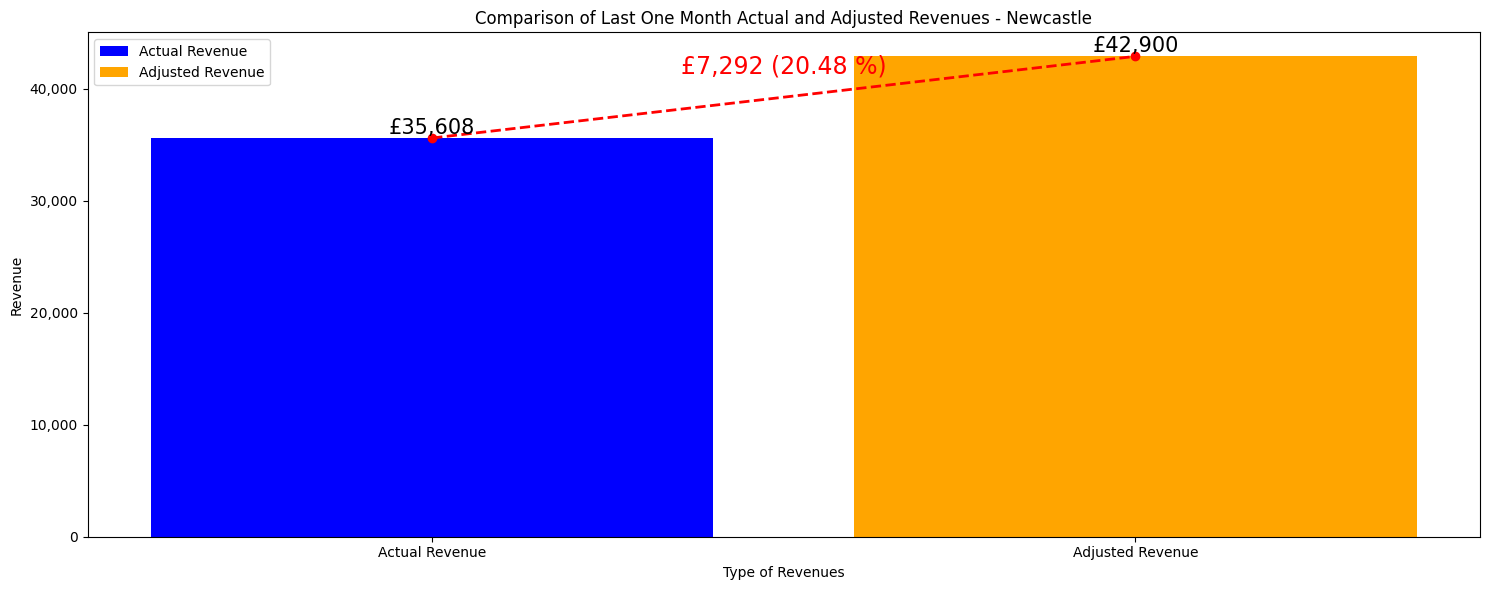

In [47]:
plot_revenue_comparison_overall(df_merged_revenue)

---